# Preamble

To import the module ```ringity``` please make sure that the folder ```/ringity``` is in the same direcotry as this notebook or alternatively download ringity via ```pip install ringity```.

# Imports

In [1]:
from scipy.spatial.distance import pdist, squareform
from itertools import product as iter_product
from itertools import combinations
from numpy import pi, cos, sin, tan
from collections import Counter

import os
import time
import gzip
import tarfile
import requests
import numpy as np
import pandas as pd
import networkx as nx
import ringity as rng
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

%matplotlib inline
sns.set()

# Plot parameters

In [2]:
cemm1 = [0/255,85/255,100/255]
cemm2 = [0/255,140/255,160/255]
cemm3 = [64/255,185/255,212/255]
cemm4 = [212/255,236/255,242/255]

costume = [0/255,9/255,10/255]

sblue = sns.color_palette()[0]
sred = sns.color_palette()[1]
sgreen = sns.color_palette()[2]
sblack = sns.color_palette('bright')[7]
sblack2 = sns.color_palette('dark')[7]

In [3]:
node_col = cemm1
edge_col = cemm2

def plot_nx(G, 
            pos=None, 
            ax=None,
            node_colors = None,
            node_alpha  = 0.3, 
            edge_colors = None,
            edge_alpha  = 0.2,
            **kwargs):

    if pos is None:
        pos = nx.spring_layout(G)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8));
        fig.patch.set_alpha(0)
    if node_colors is None:
        node_colors = [node_col for v in G.nodes]
    if edge_colors is None:
        edge_colors = [edge_col for u,v in G.edges]
    nodes = nx.draw_networkx_nodes(G, pos=pos, alpha=node_alpha, ax=ax, node_color=node_colors, node_size=15, linewidths=1)
    edges = nx.draw_networkx_edges(G, pos=pos, alpha=edge_alpha, ax=ax, edge_color=edge_colors)
    ax.axis('off');
    
def plot_dgm(dgm, ax=None, **kwargs):
    x,y = zip(*[(k.birth,k.death) for k in dgm])
    d = max(y)

    if ax is None:
        fig, ax = plt.subplots()
        fig.patch.set_alpha(0)

    ax.patch.set_alpha(0)
    
    hw = 0.025 # head width of the arrow
    
    ax.set_xlim([-hw, d*1.1])
    ax.set_ylim([-hw, d*1.1])
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color(sblack2)
    
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color(sblack2)

    ax.plot(x, y, '*', markersize=5, color = cemm2);
    ax.plot([0,d],[0,d], color= [c/2 for c in cemm1], linewidth=1, linestyle='dashed');
    

def plot_bar(dgm, ax=None, cap=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)
    else:
        ax.patch.set_alpha(0)
    if cap is not None:
        for i in range(cap): dgm.append((0,0))
    bar = list(dgm.sequence)[:cap]
    ax.bar(range(len(bar)), bar, color=sblack);
    
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color(sblack2)
    
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color(sblack2)
    
    ax.tick_params(axis='both', which='major', labelsize=24)

# Lipid co-regulation network

### Preparation

In [4]:
# ---------------
# Paths and URLs
# ---------------

LIPID_FOLDER = os.getcwd() + "/data/lipid_network"
LIPID_URL    = "https://ars.els-cdn.com/content/image/1-s2.0-S0092867415006418-mmc3.xlsx"
LIPID_EXCEL_FILE = LIPID_FOLDER + "/1-s2.0-S0092867415006418-mmc3.xlsx"
LIPID_CORR_FILE = LIPID_FOLDER + "/lipid_corr.txt"

In [5]:
# --------------
# Download data
# --------------

if not os.path.exists(LIPID_FOLDER):
    os.makedirs(LIPID_FOLDER)

r = requests.get(LIPID_URL, allow_redirects=True)
with open(LIPID_EXCEL_FILE, 'wb') as f:
    f.write(r.content)

In [8]:
# -----------------------
# Calculate correlations
# -----------------------

skiprows = [168]           # No data for C20 Sphingomyelin available

genes = ['sh:Sptlc2', 'sh:CerS2', 'sh:CerS6' , 
         'sh:Smpd1' , 'sh:Asah1', 'sh:Ugcg'  , 
         'sh:CLN3'  , 'sh:Lyst' , 'sh:Ormdl1', 
         # 'sh:GFP'        (green fluorescent protein) used to normalize data
         ]

lipid_excel_df = pd.read_excel(LIPID_EXCEL_FILE, 
                   header    = 1, 
                   index_col = 0,
                   skiprows = skiprows
                  )[genes]

lipid_corr_df = lipid_excel_df.T.corr()

In [9]:
# save data
lipid_corr_df.to_csv(LIPID_CORR_FILE)

### Analysis

In [10]:
# ----------------------
# network preprocessing
# ----------------------

lipid_corr_df = pd.read_csv(LIPID_CORR_FILE, index_col=0)

c = 0.6   # threshold

G_lipid = nx.from_pandas_adjacency(lipid_corr_df.abs() > c)      # create (binary) network 
G_lipid = G_lipid.subgraph(                                      # get lcc, in case threshold was chosen too high
                max(nx.connected_components(G_lipid), key=len)) 
    
pos = nx.spring_layout(G_lipid)

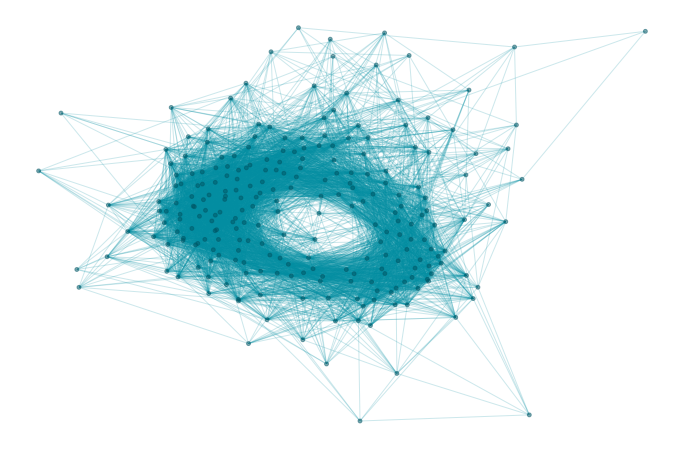

In [11]:
plot_nx(G_lipid, pos=pos, node_alpha=0.5)

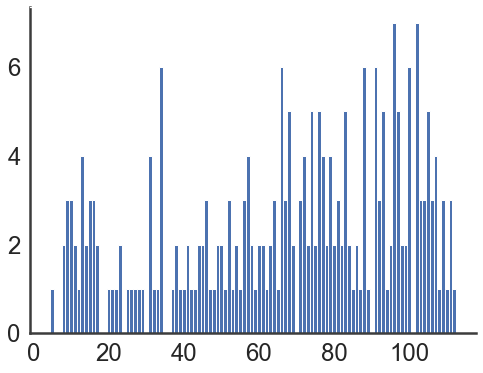

In [12]:
# ---------------------
#  degree distribution
# ---------------------

degree_sequence = sorted([d for n, d in G_lipid.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(degs, cnts, width=1, color=sblue)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

In [13]:
# ----------------------
# calclulating diagrams
# ----------------------

D_lipid   = (1-lipid_corr_df.abs()).values # calculate distance matrix
dgm_lipid = rng.diagram(D_lipid)

bb = rng.net_flow(G_lipid)
nx.set_edge_attributes(G_lipid, values=bb, name='net-flow')
dgm_lipid_c = rng.diagram(G_lipid, distance='net-flow')

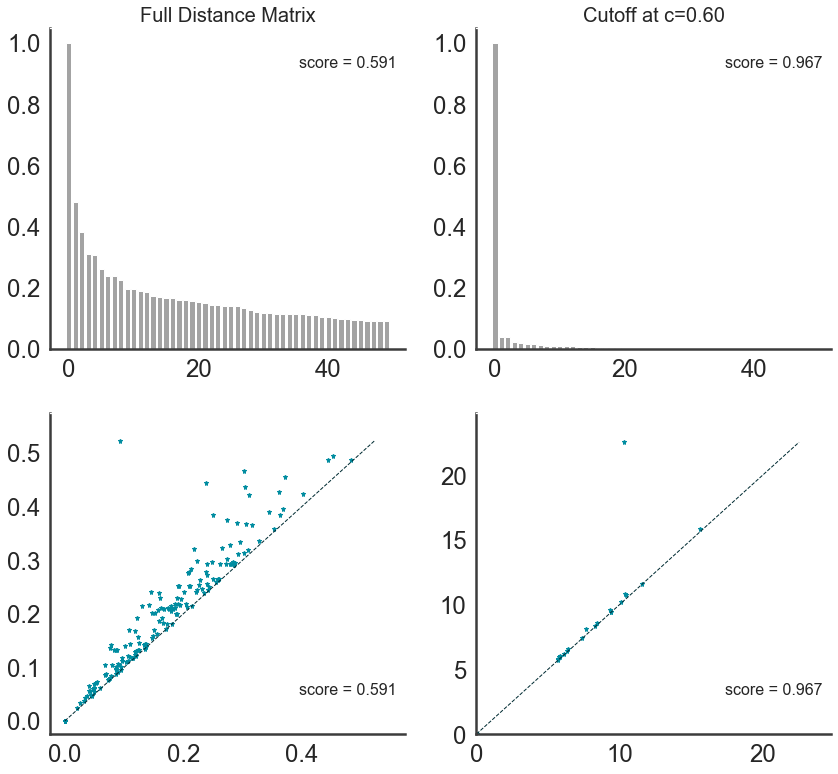

In [14]:
# --------------------
# persistence visuals
# --------------------

fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=20)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=20)

plot_bar(dgm_lipid,   ax=axes[0,0], cap=50)
plot_bar(dgm_lipid_c, ax=axes[0,1], cap=50)
plot_dgm(dgm_lipid,   ax=axes[1,0])
plot_dgm(dgm_lipid_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm_lipid.score  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=16);
axes[0,1].annotate(f'score = {dgm_lipid_c.score:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=16);
axes[1,0].annotate(f'score = {dgm_lipid.score  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=16);
axes[1,1].annotate(f'score = {dgm_lipid_c.score:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=16);

# Fibroblast proximity network

### Preparation

In [15]:
# --------------------------
# define paths and get data
# --------------------------

FIBRO_FOLDER = os.getcwd()  + "/data/fibroblast_network"
FIBRO_FILE   = FIBRO_FOLDER + "/connectivity_FLS11_data.xls"

name = "FLS18 TNF"
fibro_position_df = pd.read_excel(FIBRO_FILE, sheet_name=name)

### Analysis

In [16]:
# ----------------------
# network preprocessing
# ----------------------

d = 115    # threshold

D_fibro = squareform(pdist(                                       # distance matrix
    fibro_position_df[['Position X','Position Y','Position Z']])) 

G_fibro = nx.from_numpy_array(np.where(D_fibro > d,0,1))    # create (binary) network 
G_fibro = G_fibro.subgraph(
            max(nx.connected_components(G_fibro), key=len)) # get lcc, in case threshold was chosen too low
    
pos = nx.spring_layout(G_fibro)

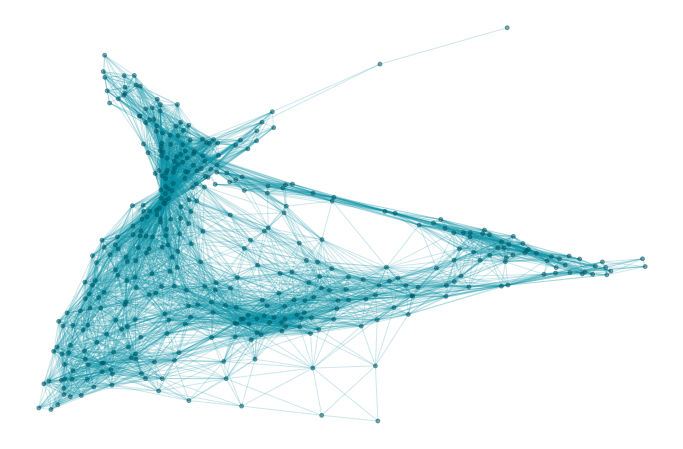

In [17]:
plot_nx(G_fibro, pos=pos, node_alpha=0.5)

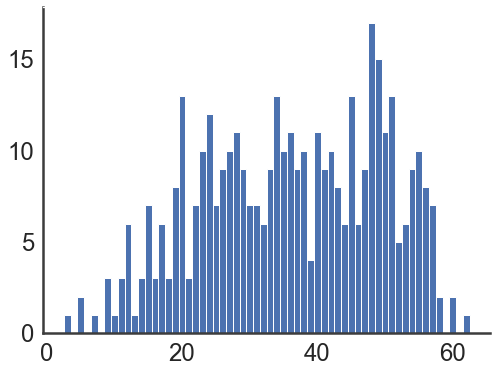

In [18]:
# --------------------
# degree distribution
# --------------------

degree_sequence = sorted([d for n, d in G_fibro.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(degs, cnts, width=1, color=sblue)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

In [19]:
# ----------------------
# calclulating diagrams
# ----------------------

dgm_fibro = rng.diagram(D_fibro)

bb = rng.net_flow(G_fibro)
nx.set_edge_attributes(G_fibro, values=bb, name='net-flow')
dgm_fibro_d = rng.diagram(G_fibro, distance='net-flow')

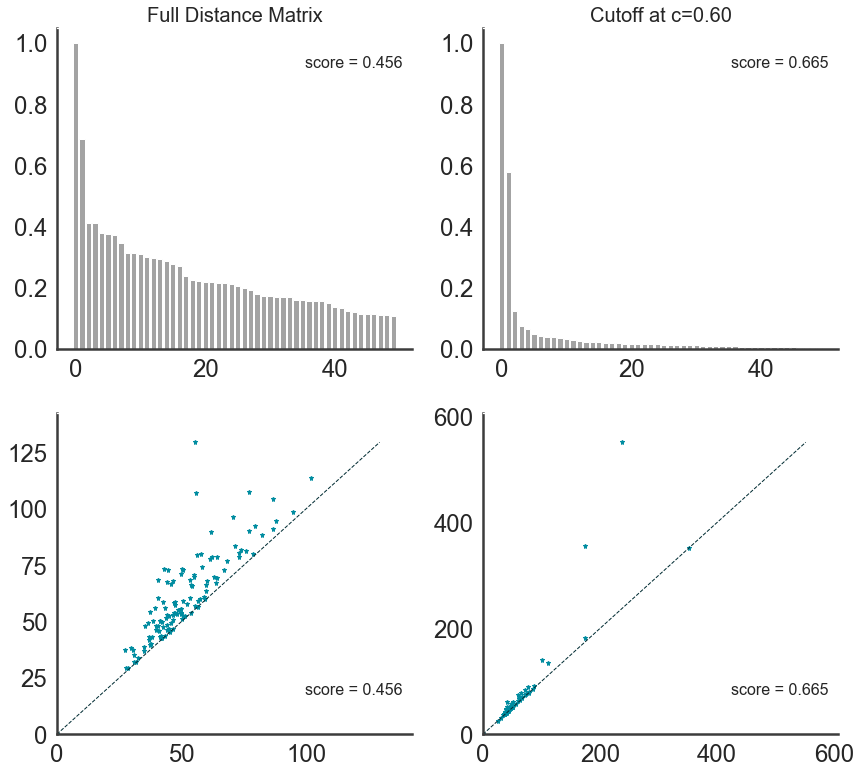

In [20]:
# --------------------
# persistence visuals
# --------------------

fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=20)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=20)

plot_bar(dgm_fibro,   ax=axes[0,0], cap=50)
plot_bar(dgm_fibro_d, ax=axes[0,1], cap=50)
plot_dgm(dgm_fibro,   ax=axes[1,0])
plot_dgm(dgm_fibro_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm_fibro.score  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=16);
axes[0,1].annotate(f'score = {dgm_fibro_d.score:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=16);
axes[1,0].annotate(f'score = {dgm_fibro.score  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=16);
axes[1,1].annotate(f'score = {dgm_fibro_d.score:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=16);

# Reactome networks

### Preparation

In [4]:
# ---------------
# Paths and URLs
# ---------------

IMMUNE_FOLDER = os.getcwd() + "/data/immune_network"
IMMUNE_FILE   = IMMUNE_FOLDER + "/reactome_smbl.tgz"
IMMUNE_URL    = "https://reactome.org/download/current/homo_sapiens.3.1.sbml.tgz"

ROOT_DIR = IMMUNE_FOLDER + "/homo_sapiens"

In [5]:
# --------------
# Download data
# --------------

if not os.path.exists(IMMUNE_FOLDER):
    os.makedirs(IMMUNE_FOLDER)

# Download all human reactions from Reactome in SBML format
urllib.request.urlretrieve(IMMUNE_URL, IMMUNE_FILE)
tar = tarfile.open(IMMUNE_FILE)
tar.extractall(ROOT_DIR)
tar.close()

In [ ]:
# ---------------
# Set parameters 
# ---------------

ringy_threshold = 0.6
min_nodes = 100

In [45]:
# --------------------------------
# Extract ringy Reactome pathways
# --------------------------------

ringiy_graph_list = []
namespace = "{http://www.sbml.org/sbml/level3/version1/core}"

for pathway_file in os.listdir(ROOT_DIR):
    sbml = ET.parse(ROOT_DIR + '/' + pathway_file)

    model = sbml.getroot().find(namespace + "model")
    reactions =      model.find(namespace + "listOfReactions")

    # List species annotated as "simple chemical" to remove them from networks, 
    # to avoid creating star structures with the most common small molecules
    small_molecs = {term.attrib['id'] for term in model.find(namespace + "listOfSpecies") 
                          if term.attrib.get('sboTerm') == "SBO:0000247"}
    
    pathway_name = model.attrib['name']
    pathway_ID   = model.attrib['id']
    
    # Create directed graph here
    G = nx.Graph(name=model.attrib['name'],
                 id=model.attrib['id']) 
    
    for reaction in reactions:
        
        list_of_products  = reaction.find(namespace + "listOfProducts")
        list_of_reactants = reaction.find(namespace + "listOfReactants")
        
        if (not list_of_products) or (not list_of_reactants):
            continue
        
        products  = {product.attrib['species'] for product in list_of_products
                            if product.attrib['species'] not in small_molecs}
        reactants = {reagent.attrib['species'] for reagent in list_of_reactants
                            if reagent.attrib['species'] not in small_molecs}
            
        # Add edge from reagents to products
        G.add_edges_from((r,p) for (r,p) in iter_product(reactants,products))
    
    if len(G.edges):
        H = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        if len(H) < min_nodes:
            continue
        dgm = rng.diagram(H)
        if dgm.score >= ringy_threshold:
            ringiy_graph_list.append(H)
            print(G.name)
            print('#Nodes in graph: ', len(G))
            print('#Nodes in LCC:   ', len(H))
            print('ring-score:      ', round(dgm.score,3))
            print()

Interferon Signaling
#Nodes in graph:  142
#Nodes in LCC:    110
ring-score:       0.91

Signaling by Nuclear Receptors
#Nodes in graph:  323
#Nodes in LCC:    221
ring-score:       0.71

HCMV Late Events
#Nodes in graph:  114
#Nodes in LCC:    114
ring-score:       0.69

Transcriptional Regulation by MECP2
#Nodes in graph:  120
#Nodes in LCC:    109
ring-score:       1

Homology Directed Repair
#Nodes in graph:  112
#Nodes in LCC:    104
ring-score:       0.61

Adaptive Immune System
#Nodes in graph:  485
#Nodes in LCC:    124
ring-score:       0.65

Hemostasis
#Nodes in graph:  580
#Nodes in LCC:    153
ring-score:       0.9

Signaling by Interleukins
#Nodes in graph:  773
#Nodes in LCC:    394
ring-score:       0.6

Transcriptional regulation by RUNX1
#Nodes in graph:  208
#Nodes in LCC:    197
ring-score:       0.79

Cytokine Signaling in Immune system
#Nodes in graph:  1150
#Nodes in LCC:    588
ring-score:       0.78



### Analysis

In [40]:
# ---------------
# Choose network
# ---------------

graph_name = "Interferon Signaling"

G_immune, = [G for G in ringiy_graph_list if G.name == graph_name]
pos = nx.spring_layout(G_immune)

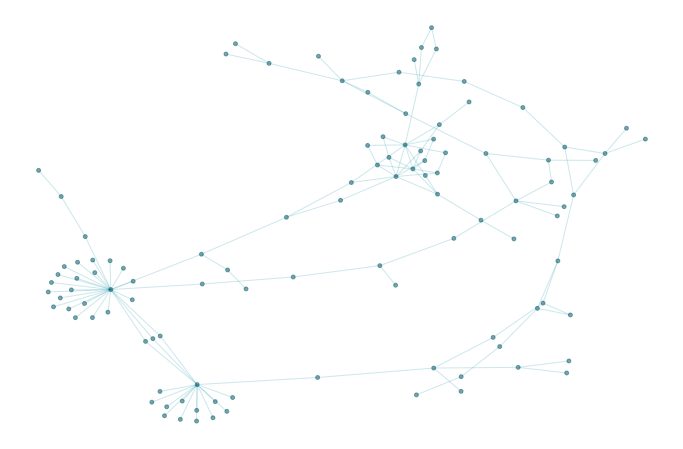

In [41]:
plot_nx(G_immune, pos=pos, node_alpha=0.5)

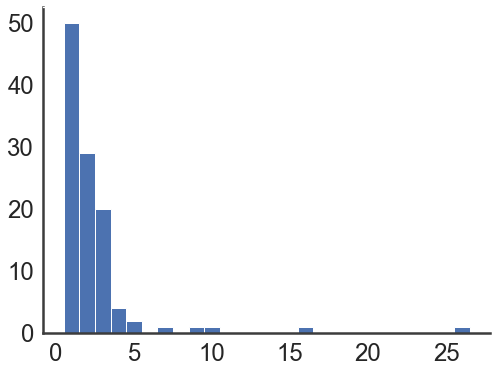

In [42]:
# ---------------------
#  degree distribution
# ---------------------

degree_sequence = sorted([d for n, d in G_immune.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(degs, cnts, width=1, color=sblue)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

In [43]:
# ----------------------
# calclulating diagrams
# ----------------------

dgm_immune = rng.diagram(G_immune)

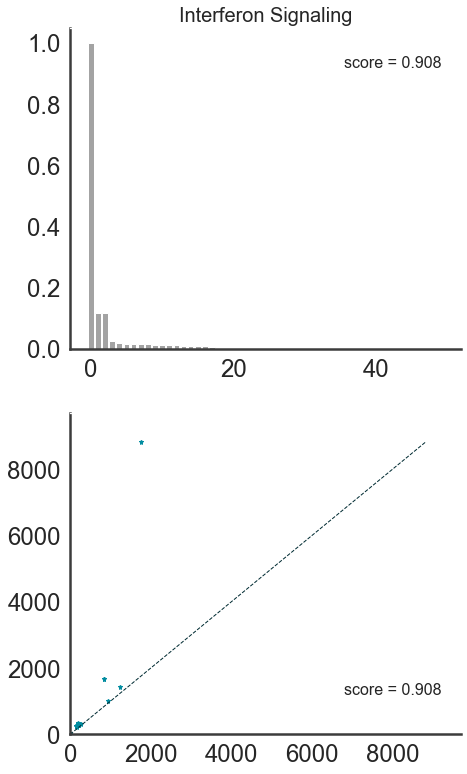

In [44]:
# --------------------
# persistence visuals
# --------------------

fig, axes = plt.subplots(2, figsize=(7,13))

axes[0].set_title(graph_name, fontsize=20)

plot_bar(dgm_immune, ax=axes[0], cap=50)
plot_dgm(dgm_immune, ax=axes[1])

axes[0].annotate(f'score = {dgm_immune.score  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=16);
axes[1].annotate(f'score = {dgm_immune.score  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=16);

## Ego-networks

## Combined networks

### Preparation

In [8]:
# ---------------
# Paths and URLs
# ---------------

EGO_FOLDER = os.getcwd() + "/data/ego_network"
EGO_URL    = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
EGO_EDGELIST_FILE = EGO_FOLDER + "/facebook_combined.txt.gz"

In [9]:
# --------------
# Download data
# --------------

if not os.path.exists(EGO_FOLDER):
    os.makedirs(EGO_FOLDER)

r = requests.get(EGO_URL, allow_redirects=True)
with open(EGO_EDGELIST_FILE, 'wb') as f:
    f.write(r.content)

### Analysis

In [47]:
G_ego = nx.read_edgelist(EGO_EDGELIST_FILE)

pos = nx.spring_layout(G_ego)

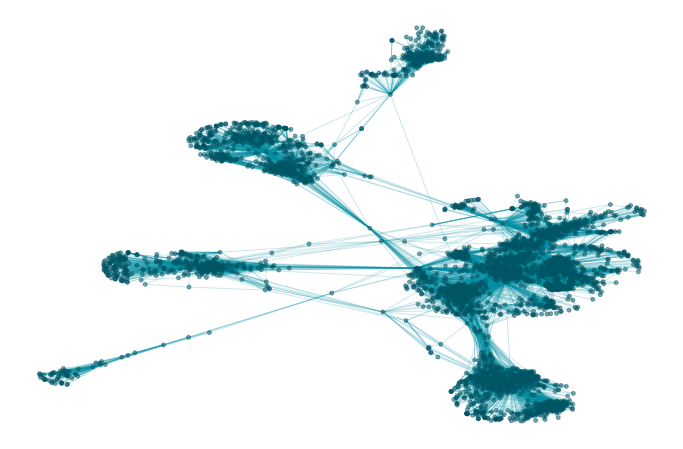

In [48]:
plot_nx(G_ego, pos=pos, node_alpha=0.5)
#plt.savefig("/Users/markusyoussef/Desktop/ego_network/visualisation.png")

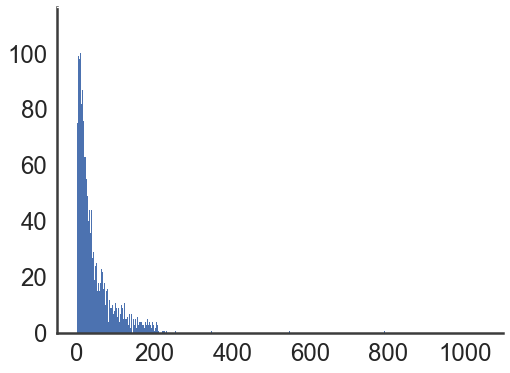

In [49]:
degree_sequence = sorted([d for n, d in G_ego.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue, linewidth=0)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

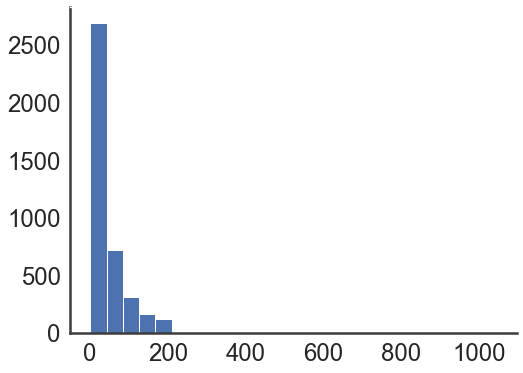

In [53]:
degree_sequence = sorted([d for n, d in G_ego.degree()])

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.hist(degree_sequence, bins=25)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

plt.savefig("/Users/markusyoussef/Desktop/ego_network/deg_distribution.pdf")

In [54]:
c = nx.average_clustering(G_ego)
print(c)
d = nx.average_shortest_path_length(G_ego)
print(d)

0.6055467186200876
3.6925068496963913


In [55]:
G_ego.number_of_nodes(), G_ego.number_of_edges()

(4039, 88234)

In [56]:
# ----------------------
# calclulating diagrams
# ----------------------

dgm_ego = rng.diagram(G_ego)

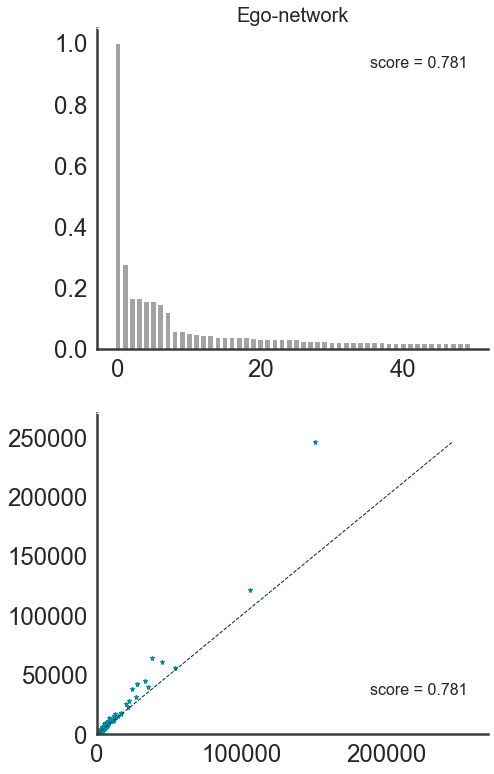

In [59]:
# --------------------
# persistence visuals
# --------------------

fig, axes = plt.subplots(2, figsize=(7,13))

axes[0].set_title("Ego-network", fontsize=20)

plot_bar(dgm_ego, ax=axes[0], cap=50)
plot_dgm(dgm_ego, ax=axes[1])

axes[0].annotate(f'score = {dgm_ego.score  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=16);
axes[1].annotate(f'score = {dgm_ego.score  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=16);

## Individual networks

### Preparation

In [16]:
# ---------------
# Paths and URLs
# ---------------

EGO_FOLDER = os.getcwd() + "/data/ego_network"
EGO_URL    = "https://snap.stanford.edu/data/facebook.tar.gz"
EGO_TAR = EGO_FOLDER + "/facebook.tar.gz"

In [17]:
# --------------
# Download data
# --------------

if not os.path.exists(EGO_FOLDER):
    os.makedirs(EGO_FOLDER)

r = requests.get(EGO_URL, allow_redirects=True)
with open(EGO_TAR, 'wb') as f:
    f.write(r.content)

tf = tarfile.open(EGO_TAR)
tf.extractall(EGO_FOLDER)

### Analysis

In [23]:
# ---------------
# Set parameters 
# ---------------

min_nodes = 100

In [26]:
# --------------------------------
# Extract ego-networks
# --------------------------------


for file in os.listdir(f"{EGO_FOLDER}/facebook"):
    if not file.endswith('edges'):
        continue
    
    G = nx.read_edgelist(f"{EGO_FOLDER}/facebook/{file}")
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len))
    
    if H.number_of_nodes() < min_nodes:
        continue
    
    dgm = rng.diagram(H)
    
    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

ID:  686
#Nodes in graph:  168
#Nodes in LCC:    168
ring-score:       0.42

ID:  348
#Nodes in graph:  224
#Nodes in LCC:    224
ring-score:       0.661

ID:  3437
#Nodes in graph:  534
#Nodes in LCC:    532
ring-score:       0.142

ID:  1912
#Nodes in graph:  747
#Nodes in LCC:    744
ring-score:       0.224

ID:  1684
#Nodes in graph:  786
#Nodes in LCC:    775
ring-score:       0.174

ID:  0
#Nodes in graph:  333
#Nodes in LCC:    324
ring-score:       0.264

ID:  414
#Nodes in graph:  150
#Nodes in LCC:    148
ring-score:       0.249

ID:  107
#Nodes in graph:  1034
#Nodes in LCC:    1034
ring-score:       0.401



# Foodweb networks

### Preparation

In [4]:
FOODWEB_FOLDER = os.getcwd() + "/data/foodweb_networks"

## Bipartite networks

In [5]:
# ---------------
# Set parameters 
# ---------------

min_nodes = 100

In [6]:
# -------------------------
# Extract foodweb networks
# -------------------------


for file in os.listdir(FOODWEB_FOLDER):
    if not file.endswith('csv') or file == 'references.csv':
        continue
    
 #  Load table 
    foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/{file}", index_col=0)
    consumers = foodweb_matrix.index
    resources = foodweb_matrix.columns

 #  Construct network
    foodweb_network = nx.Graph()
    foodweb_network.add_nodes_from(consumers)
    foodweb_network.add_nodes_from(resources)
    for con,res in iter_product(consumers, resources):
        if foodweb_matrix.loc[con,res]:
            foodweb_network.add_edge(con,res)
    
    G = foodweb_network
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len)).copy()

    if H.number_of_nodes() < min_nodes:
        continue

    dgm = rng.diagram(H)

    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

ID:  M_PL_044
#Nodes in graph:  719
#Nodes in LCC:    712
ring-score:       0.347

ID:  FW_014_03
#Nodes in graph:  109
#Nodes in LCC:    108
ring-score:       0.019

ID:  M_PL_051
#Nodes in graph:  104
#Nodes in LCC:    104
ring-score:       0.164

ID:  M_PL_053
#Nodes in graph:  393
#Nodes in LCC:    364
ring-score:       0.204

ID:  M_PL_047
#Nodes in graph:  205
#Nodes in LCC:    205
ring-score:       0.025

ID:  M_PL_056
#Nodes in graph:  456
#Nodes in LCC:    456
ring-score:       0.131

ID:  FW_014_04
#Nodes in graph:  113
#Nodes in LCC:    112
ring-score:       0.02

ID:  M_PL_043
#Nodes in graph:  110
#Nodes in LCC:    110
ring-score:       0.106

ID:  M_PL_057
#Nodes in graph:  997
#Nodes in LCC:    997
ring-score:       0.361

ID:  M_PL_055
#Nodes in graph:  259
#Nodes in LCC:    253
ring-score:       0.104

ID:  M_PL_054
#Nodes in graph:  431
#Nodes in LCC:    414
ring-score:       0.335

ID:  FW_011
#Nodes in graph:  105
#Nodes in LCC:    105
ring-score:       0.166

ID:  

### Analysis

In [7]:
foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/M_SD_034.csv", index_col=0)
consumers = foodweb_matrix.index
resources = foodweb_matrix.columns

#  Construct network
G_food = nx.Graph()
G_food.add_nodes_from(consumers)
G_food.add_nodes_from(resources)
for con,res in iter_product(consumers, resources):
    if foodweb_matrix.loc[con,res]:
        G_food.add_edge(con,res)

pos = nx.spring_layout(G_food)

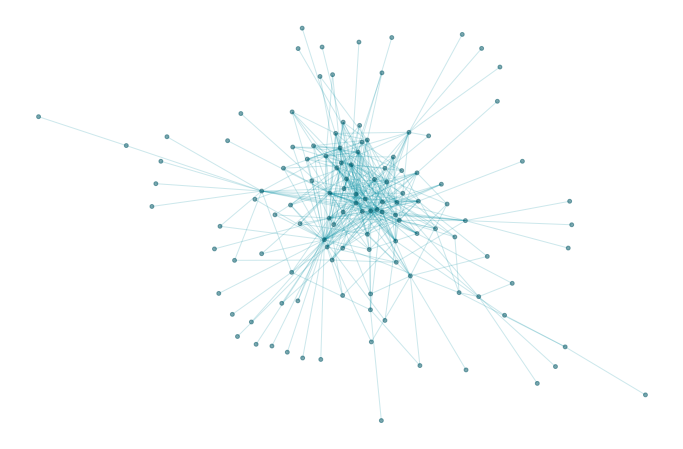

In [11]:
plot_nx(G_food, pos=pos, node_alpha=0.5)
plt.savefig("/Users/markusyoussef/Desktop/foodweb_visualization.pdf")

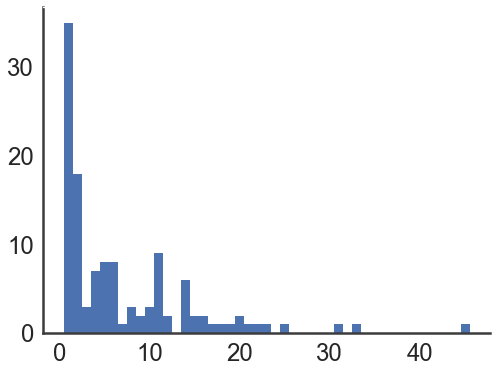

In [13]:
degree_sequence = sorted([d for n, d in G_food.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(degs, cnts, width=1, color=sblue, linewidth=0)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

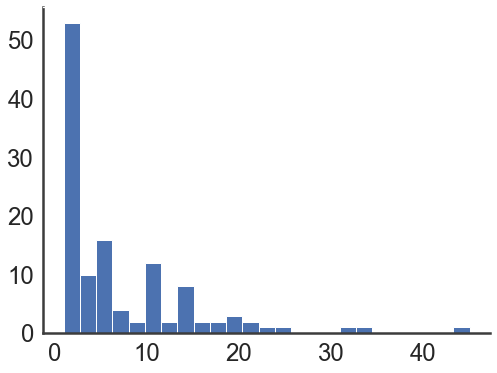

In [16]:
degree_sequence = sorted([d for n, d in G_food.degree()])

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.hist(degree_sequence, bins=25)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

plt.savefig("/Users/markusyoussef/Desktop/food_distribution.png")

## Consumer networks

In [52]:
# -------------------------
# Extract foodweb networks
# -------------------------


for file in os.listdir(FOODWEB_FOLDER):
    if not file.endswith('csv') or file == 'references.csv':
        continue
    
 #  Load table 
    foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/{file}", index_col=0)
    consumers = foodweb_matrix.index

 #  Construct network
    consumer_network = nx.Graph()
    consumer_network.add_nodes_from(consumers)
    
    for con1,con2 in combinations(consumers,2):
        if (foodweb_matrix.loc[con1] + foodweb_matrix.loc[con2]).any():
            consumer_network.add_edge(con1, con2)
    
    G = consumer_network
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len)).copy()

    if H.number_of_nodes() < min_nodes or nx.density(H) == 1:
        continue

    dgm = rng.diagram(H)

    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

ID:  FW_014_03
#Nodes in graph:  109
#Nodes in LCC:    109
ring-score:       0

ID:  FW_014_04
#Nodes in graph:  113
#Nodes in LCC:    113
ring-score:       0

ID:  FW_011
#Nodes in graph:  105
#Nodes in LCC:    105
ring-score:       0

ID:  FW_015_04
#Nodes in graph:  107
#Nodes in LCC:    107
ring-score:       0



## Resources networks

In [55]:
# -------------------------
# Extract foodweb networks
# -------------------------


for file in os.listdir(FOODWEB_FOLDER):
    if not file.endswith('csv') or file == 'references.csv':
        continue
    
 #  Load table 
    foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/{file}", index_col=0)
    resources = foodweb_matrix.columns

 #  Construct network
    resource_network = nx.Graph()
    resource_network.add_nodes_from(resources)
    
    for res1,res2 in combinations(resources,2):
        if (foodweb_matrix[res1] + foodweb_matrix[res2]).any():
            consumer_network.add_edge(res1, res2)
    
    G = resource_network
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len)).copy()

    if H.number_of_nodes() < min_nodes or nx.density(H) == 1:
        continue
    break

    dgm = rng.diagram(H)

    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

## Genes
<center><h3 style="color:darkred"> >>> CAUTION - Big Data! <<<  </h3></center><p>

*Uncomment lines if the data is not produced yet.*

### Network processing

In [336]:
c = 0.95

# C = np.genfromtxt('data/biological_networks/genes/gene_corr.txt')
# D = 1-np.abs(C)
# A = np.where(np.abs(C)>c,1,0)
# np.fill_diagonal(A,0)
# G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

# for _, _, data in G.edges(data=True): data.pop('weight',None)
# nx.write_edgelist(G, f'data/biological_networks/genes/gene_c{c:.2f}_edgelist.csv', data=False)

### Network visuals - this might take a while ...    
&nbsp;&nbsp;&nbsp;&nbsp;(~15min on my computer)

*Load network for rerunning the visuals.*

In [337]:
G = nx.read_edgelist(f'data/biological_networks/genes/gene_c{c:.2f}_edgelist.csv', nodetype=int, data=False)

*Precompute/load layout positions.*

In [235]:
# pos = nx.spring_layout(G)
# with open(f'data/biological_networks/genes/gene_c{c:.2f}_pos.pkl', 'wb') as f:
#     pickle.dump(pos, f)

In [64]:
with open(f'data/biological_networks/genes/gene_c{c:.2f}_pos.pkl', 'rb') as f:
    pos = pickle.load(f)

*Plotting the network; this is the most time-consuming step. You might wanna save it right away.*

In [492]:
# pos = comb(pos)      # moves sticky-out edges closer to the center
# plot_nx(G, pos=pos)

*Save plot with precomputed layout positions.*

In [494]:
plot_nx(G, path=f'data/biological_networks/genes/gene_c{c:.2f}_nx.pdf',  silence=True, pos=pos)

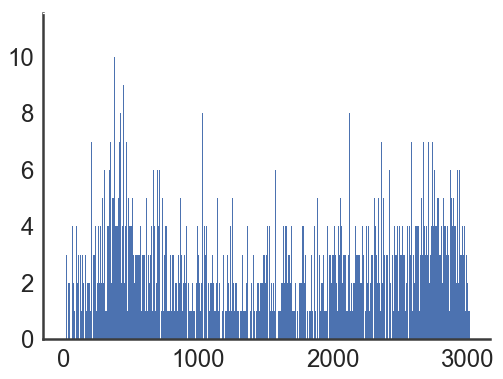

In [343]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue, linewidth=0)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/genes/gene_c{c:.2f}_deg_{mode}.pdf', transparent=True)

In [66]:
deg_fig.savefig(f'data/biological_networks/genes/gene_c{c:.2f}_deg.pdf', transparent=True)

### Calculating diagrams - you probably won't be able to calculate this on a regular computer...    
&nbsp;&nbsp; (Some of these calculations require up to 256GB RAM and can take up to 24h.)

In [57]:
# rng.induce_toa(G, split=10)
# nx.write_edgelist(G, f'data/biological_networks/genes/gene_c{c:.2f}_weightlist.csv')

In [58]:
# dgm = rng.diagram(G, toa='toa')
# dgm.save(f'data/biological_networks/genes/gene_c{c:.2f}_dgm.csv', )

In [59]:
# dgm = rng.ripser(D)
# dgm.save('data/biological_networks/genes/gene_dgm.csv')

In [214]:
dgm = rng.load_dgm('data/biological_networks/genes/gene_dgm.csv')
dgm_c = rng.load_dgm(f'data/biological_networks/genes/gene_c{c:.2f}_dgm.csv')

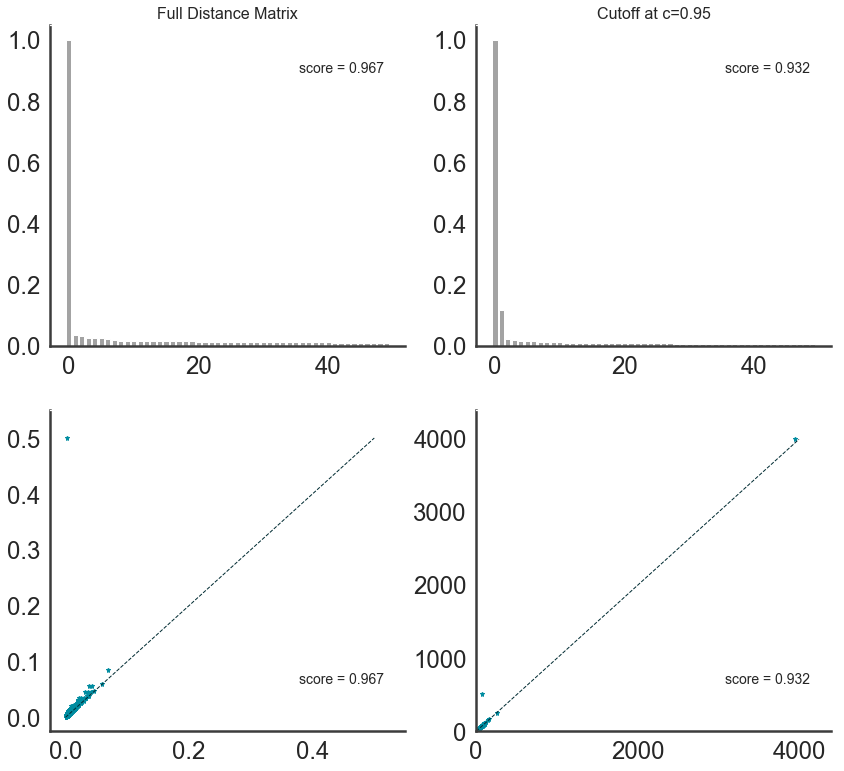

In [215]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_c, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);

### Write summary - this might take a while ...
&nbsp;&nbsp;&nbsp;&nbsp;(~12h/34h on my computer)

In [62]:
write_summary(G, dgm=dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_summary.html')

### Save persistent visuals

In [216]:
plot_dgm(dgm, path=f'data/biological_networks/genes/gene_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/genes/gene_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_bar.pdf', silence=True, cap=30)

## Soil

### MSE

In [34]:
# network preprocessing
d = 90

D = np.genfromtxt('data/biological_networks/soil/soil_gray_mse.txt')
A = np.where(np.abs(D)>d,0,1)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G, iterations=1000)

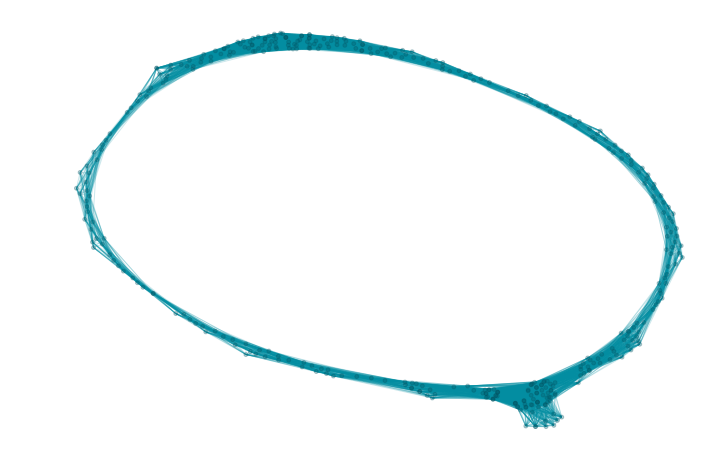

In [77]:
# network visuals
plot_nx(G, pos=pos)

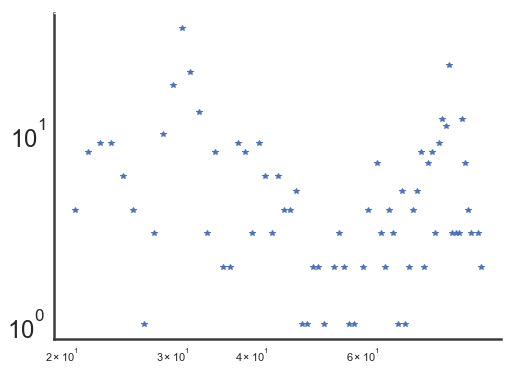

In [38]:
mode = 'loglog'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, '*', color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/soil/soil_mse_d{d:.2f}deg_{mode}.pdf', transparent=True)

In [80]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_d = rng.diagram(G, toa='toa')

In [81]:
# add some vacuous points to the diagram to make the barplot look nicer
for i in range(10): dgm_d.append((0,0))

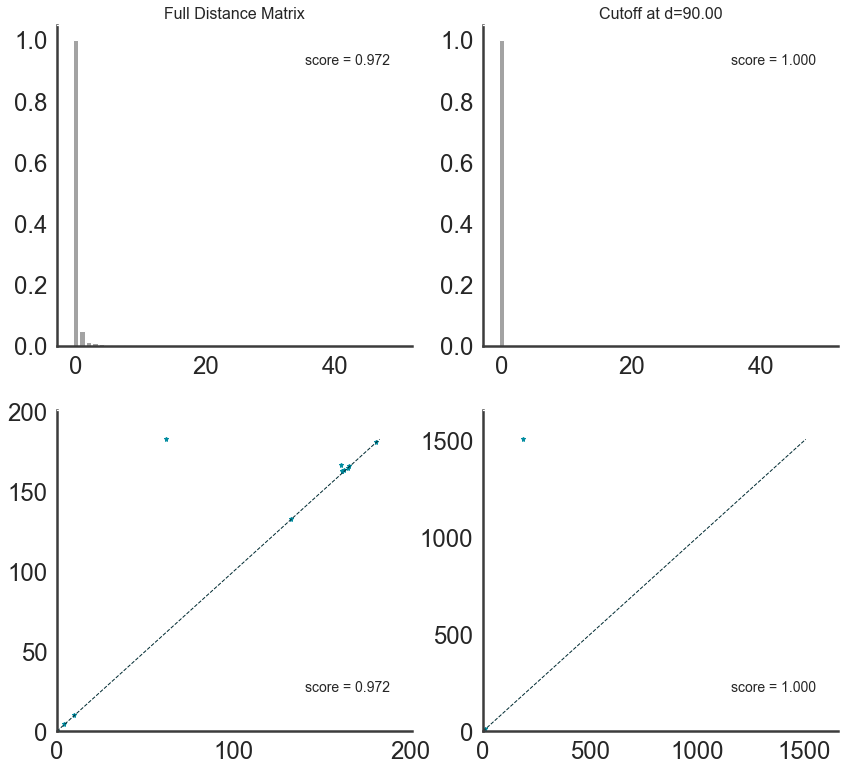

In [82]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at d={d:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_d, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save data

In [83]:
# save data
dgm.save(  f'data/biological_networks/soil/soil_mse_dgm.csv')
dgm_d.save(f'data/biological_networks/soil/soil_mse_d{d:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/soil/soil_mse_d{d:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/soil/soil_mse_d{d:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_summary.html')

In [84]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/soil/soil_mse_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/soil/soil_mse_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_bar.pdf', silence=True, cap=30)
plot_nx(G,      path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_nx.pdf',  silence=True, pos=pos)

deg_fig.savefig(f'data/biological_networks/soil/soil_mse_d{d:.2f}_deg.pdf', transparent=True)

### SSIM

In [161]:
# network preprocessing
c = 0.95

C = np.genfromtxt('data/biological_networks/soil/soil_gray_ssim.txt')
D = 1-np.abs(C)
A = np.where(np.abs(C)>c,1,0)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

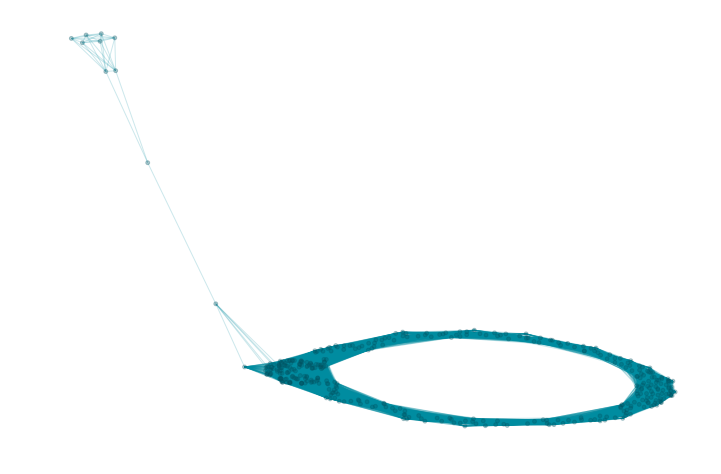

In [162]:
# network visuals
plot_nx(G, pos=pos)

In [163]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_c = rng.diagram(G, toa='toa')

In [167]:
# add some vacuous points to the diagram to make the barplot look nicer
for i in range(10): dgm.append((0,0))
for i in range(10): dgm_c.append((0,0))

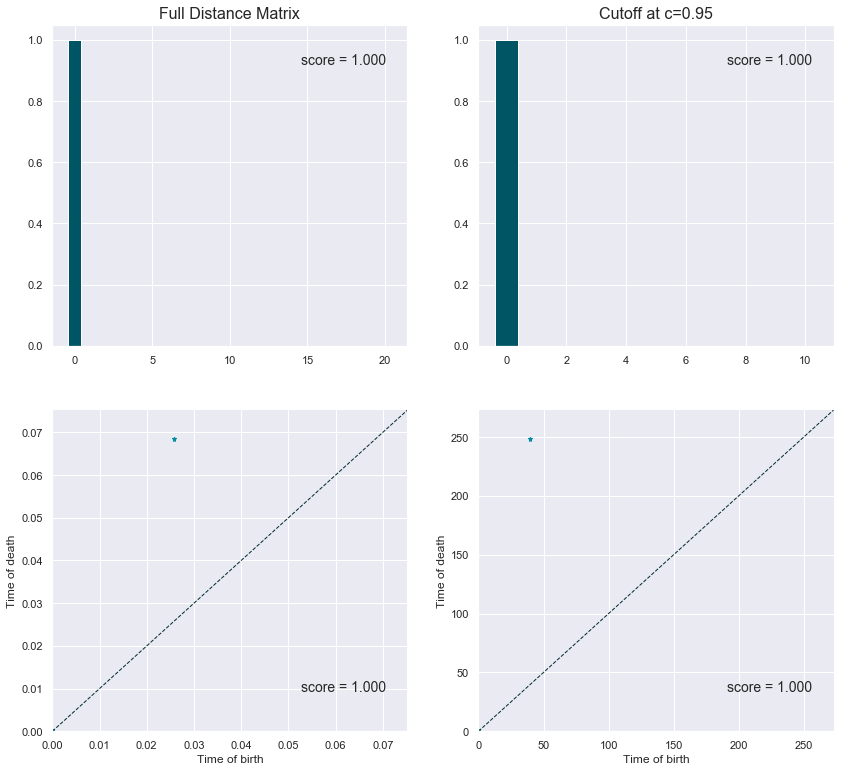

In [168]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_c, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save Data

In [171]:
# save data
dgm.save(  f'data/biological_networks/soil/soil_ssim_dgm.csv')
dgm_c.save(f'data/biological_networks/soil/soil_ssim_c{c:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/soil/soil_ssim_c{c:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/soil/soil_ssim_c{c:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_summary.html')

In [172]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/soil/soil_ssim_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/soil/soil_ssim_bar.pdf', silence=True, cap=50)

plot_dgm(dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_bar.pdf', silence=True, cap=50)
plot_nx(G,      path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_nx.pdf',  silence=True, pos=pos)

## Interferons 

In [39]:
# network preprocessing
G = nx.read_edgelist('data/biological_networks/IFNs/IFN_edgelist.csv')
G = G.to_undirected()
G = max(nx.connected_component_subgraphs(G), key=len)
G = nx.convert_node_labels_to_integers(G)

pos = nx.spring_layout(G, iterations=1000)

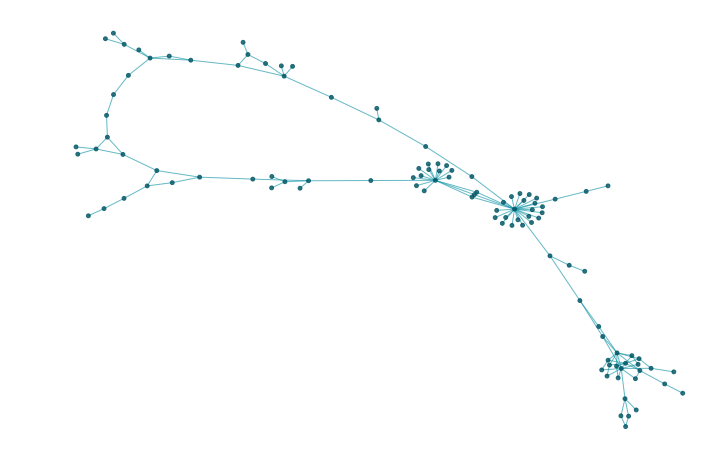

In [40]:
# network visuals
# pos = comb(pos) # moves sticky-out edges closer to the center
plot_nx(G, pos=pos, node_alpha=0.8, edge_alpha=0.6)

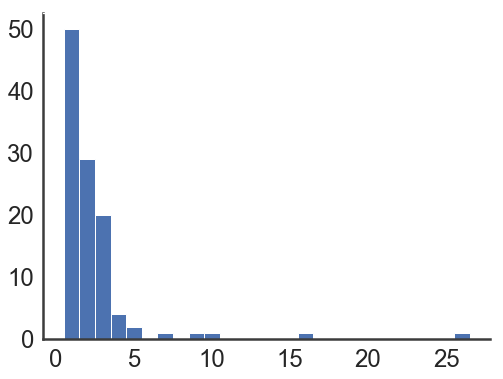

In [44]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/IFNs/IFN_deg_{mode}.pdf', transparent=True)

In [88]:
# calclulating diagrams
rng.induce_toa(G)
dgm = rng.diagram(G, toa='toa')

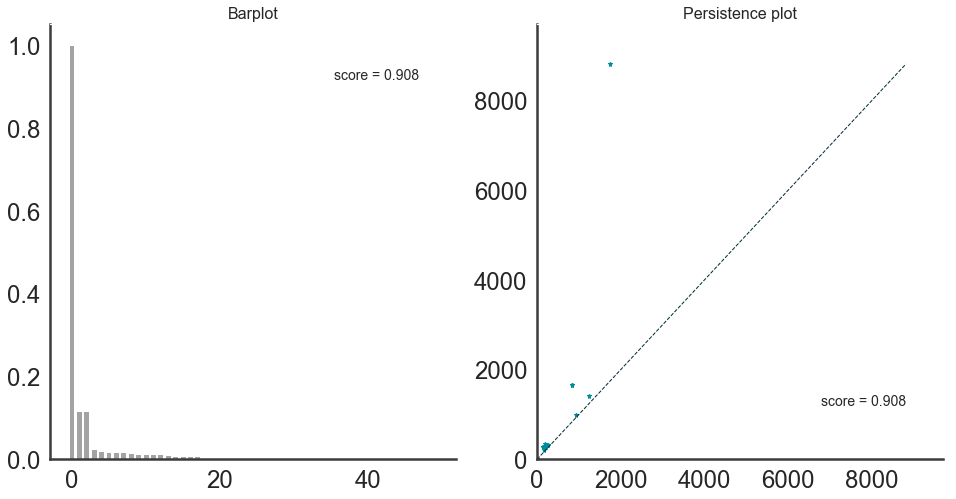

In [89]:
# persistence visuals
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].set_title('Barplot', fontsize=16)
axes[1].set_title('Persistence plot', fontsize=16)

plot_bar(dgm, ax=axes[0], cap=50)
plot_dgm(dgm, ax=axes[1])

axes[0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save data

In [90]:
# save data
dgm.save(  f'data/biological_networks/IFNs/IFN_dgm.csv')
nx.write_edgelist(G, f'data/biological_networks/IFNs/IFN_weightlist.csv')
write_summary(G, dgm, path=f'data/biological_networks/IFNs/IFN_summary.html')

In [91]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/IFNs/IFN_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/IFNs/IFN_bar.pdf', silence=True, cap=30)
plot_nx(G,    path=f'data/biological_networks/IFNs/IFN_nx.pdf',  silence=True, 
        pos=pos, node_alpha=0.8, edge_alpha=0.6)

deg_fig.savefig(f'data/biological_networks/IFNs/IFN_deg.pdf', transparent=True)